## This is the code originally shared by Prof. J. Self, first author of the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.

## And then modified by R. Li to get thermodynamic factors (TDF) of salt, solvent (EC) and their cross terms


In [26]:
# Simplified code for JPCL paper (draft) for Ruihe Li - JS 2024-02-13
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy
import sympy as sy; from sympy import symbols,diff
from scipy import stats,integrate
plt.rc('font', size=14)
import pandas

In [27]:
###### 1) global variables ######
#################################
T0EC,T0EMC,R=273.15+38.05,273.15+-53.8,8.31
m_bar_EC,m_bar_EMC=0.088,0.104
HfusEC,HfusEMC=13020,11240 # J/mol (ding) # J/mol (ding)
#### Fitted ####
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636] 
######numerical variables####
nopoints=200000
###### functions #########
def diff_central(a, b):   # self defined function to do differential
    xdc0,xdc1,xdc2 = a[:-2],a[1:-1],a[2:]
    ydc0,ydc1,ydc2 = b[:-2],b[1:-1],b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
#############

In [28]:
######## 2) Activities of EC ##########################
######################## EC - LiPF6 ###########################
def a32(xx_exp,m_e, para_i_salt ): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EC)) * 
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
########################### EC - EMC ##########################
def a31(xx_exp,X1,para_i_j): # i=EC, j=EMC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*xx_exp(
        c_i_j*X1**2 + 
        d_i_j*X1**3 + 
        e_i_j*X1**4)
    return(temp)

########### 3)  Fitting Activities of EMC ###################
####################### EMC - LiPF6 $########################
def a12(xx_exp,m_e,para_i_salt): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EMC)) *
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
################################## parametrized ##################################
def a13(xx_exp,X1,para_i_j): # i=EMC j=EC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*xx_exp(
        c_i_j*X1**2  +  
        d_i_j*X1**3  + 
        e_i_j*X1**4   ) #three suffix Margules
    return(temp)

In [29]:
################################################################
########### 4) Establishing mixing rules #######################
################################################################
########### binary global parameters ###########################
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671,   ]
para_EMC_EC  = [0.62190, 2.5617,   -2.5672,    ]
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]

###############   Eq. (7)  #############################
def Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_i_j_salt,X3=0,alpha=0): # aEC 
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt
    X_EMC_apo=X_EMC/(X_EMC+X_EMC*alpha)
    X_EC_apo=X_EMC*alpha
    # X2=1-X_EMC-X_EC_apo
    first_term  =X_EC_apo
    second_term =a32(xx_exp,m_e,para_EC_salt)/(1-(2*m_e)/(2*m_e+1/m_bar_EC))
    third_term  =a31(xx_exp,X_EMC_apo,para_EC_EMC) / (1-X_EMC_apo)
    fourth_term =xx_exp(
        c_i_j_salt*m_e**1.5*X_EMC_apo**2 + 
        d_i_j_salt*m_e**1.5*X_EMC_apo**3 + 
        e_i_j_salt*m_e**2*X_EMC_apo**2  )
    ai_tern = first_term*second_term*third_term*fourth_term
    return(ai_tern)#
def Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=0): # aEMC 
    # X_EMC_apo=X_EC*alpha/(X_EC*alpha+X_EC) # Self version
    X_EC_apo=X_EC/(X_EC*alpha+X_EC)   # actually it is X_EC_apo
    # X_EMC_apo=X_EC/(alpha+1E-16)/(X_EC*alpha+X_EC)
    X_EMC =X_EC/(alpha+1E-16)
    # X2=1-X3-X1test
    first_term=X_EMC
    second_term = a13(xx_exp,X_EC_apo,para_EMC_EC)/(1-X_EC_apo) 
    third_term  = a12(xx_exp,m_e,para_EMC_salt) / (
        1-  (2*m_e)/(2*m_e+1/m_bar_EMC))
    ai_tern = first_term*second_term*third_term
    return(ai_tern)

In [30]:
## based on the above function, keep the transformation outside
##################################################################   
#####  Define functions to calculate X_ij based on y_e, y_EC #####
################################################################## 
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol
m_bar_EMC= 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# assume 1 kg EC and EMC, 
n_EC  = 0.5 / m_bar_EC   # unit: mol
n_EMC = 0.5 / m_bar_0    # unit: mol
m_EC  = n_EC/ 1          # unit: mol/kg
m_EMC = n_EMC/ 1         # unit: mol/kg
print(f"When mass ratio is 1:1, mole ratio of EC and EMC are: {n_EC/n_EMC:.4f}, roughly equal to 1.2")
print(f"Molalities are: m_EC={m_EC:.4f}, m_EMC={m_EMC:.4f} mol/kg")
rho_0,rho_1,rho_2 = 1006.1, 0.02235185918895445, 0.10065156540490541
V_bar_0  = m_bar_0 / rho_0
V_bar_EC = (m_bar_EC - rho_1) / rho_0
V_bar_e = (m_bar_e - rho_2) / rho_0
def Fun_rho(c_e, c_EC):
    rho_0,rho_1,rho_2 = 1006.1, 0.02235185918895445, 0.10065156540490541
    return rho_0  + rho_1 * c_EC + rho_2 * c_e
def Fun_c_T(c_e, c_EC):
    b = (
        (m_bar_EC-m_bar_0) * c_EC 
        + (m_bar_e-2*m_bar_0)*c_e  ) 
    c_T= (Fun_rho(c_e, c_EC ) - b) / m_bar_0
    return c_T
def Fun_Trans(c_e, c_EC):
    rho  = Fun_rho(c_e, c_EC)
    c_T  = Fun_c_T(c_e, c_EC) 
    m_e  = c_e  / (rho - c_e*m_bar_e)
    X_e  = c_e  / c_T
    X_EC = c_EC / c_T
    X_EMC= 1 - 2*X_e - X_EC
    return m_e,X_EC,X_EMC
def Fun_c_T_y(y_e, y_EC):
    denominator = V_bar_0 + (V_bar_EC-V_bar_0)*y_EC + (V_bar_e-2*V_bar_0)*y_e
    return 1 / denominator
def Fun_Trans_y2m(y_e, y_EC):
    c_T  = Fun_c_T_y(y_e, y_EC) 
    c_e  = y_e * c_T
    c_EC = y_EC* c_T
    rho  = Fun_rho(c_e, c_EC)
    m_e  = c_e  / (rho - c_e*m_bar_e)
    X_e  = y_e
    X_EC = y_EC
    X_EMC= 1 - 2*X_e - X_EC
    return m_e,X_EC,X_EMC
def Fun_a_EC_y(y_e, y_EC):
    m_e,X_EC,X_EMC = Fun_Trans_y2m(y_e, y_EC)
    alpha = X_EC / X_EMC
    a_EC=Fun_a_EC_simplified(sy.exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    return a_EC
def Fun_a_EMC_y(y_e, y_EC):
    m_e,X_EC,X_EMC = Fun_Trans_y2m(y_e, y_EC)
    alpha = X_EC / X_EMC
    a_EMC = Fun_a_EMC_simplified(sy.exp,m_e,X_EC,alpha=alpha)
    return a_EMC


def Fun_X_ee_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    a_EMC= Fun_a_EMC_y(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC

    first_term = -y_EC * diff(sy.log(a_EC),y_e)
    second_term= -y_EMC* diff(sy.log(a_EMC),y_e)

    return first_term + second_term - 2

def Fun_X_eo_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    a_EMC= Fun_a_EMC_y(y_e, y_EC)
    y_EMC= 1 - 2*y_e - y_EC
    first_term = -y_EC * diff(sy.log(a_EC),y_EC)
    second_term= -y_EMC* diff(sy.log(a_EMC),y_EC)
    return first_term + second_term
def Fun_X_oe_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    return y_EC * diff(sy.log(a_EC),y_e)

def Fun_X_oo_y(y_e,y_EC):
    a_EC = Fun_a_EC_y (y_e, y_EC)
    return y_EC * diff(sy.log(a_EC),y_EC) - 1


When mass ratio is 1:1, mole ratio of EC and EMC are: 1.1822, roughly equal to 1.2
Molalities are: m_EC=5.6778, m_EMC=4.8028 mol/kg


In [31]:
plt.rc('font', size=17)

/tmp/ipykernel_714/1348302901.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(y_EC_list))
/home/ruihe_li/EnvPBGEM_ECDrag2/lib/python3.10/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


Text(0.5, 0, '$y_\\mathrm{e}$')

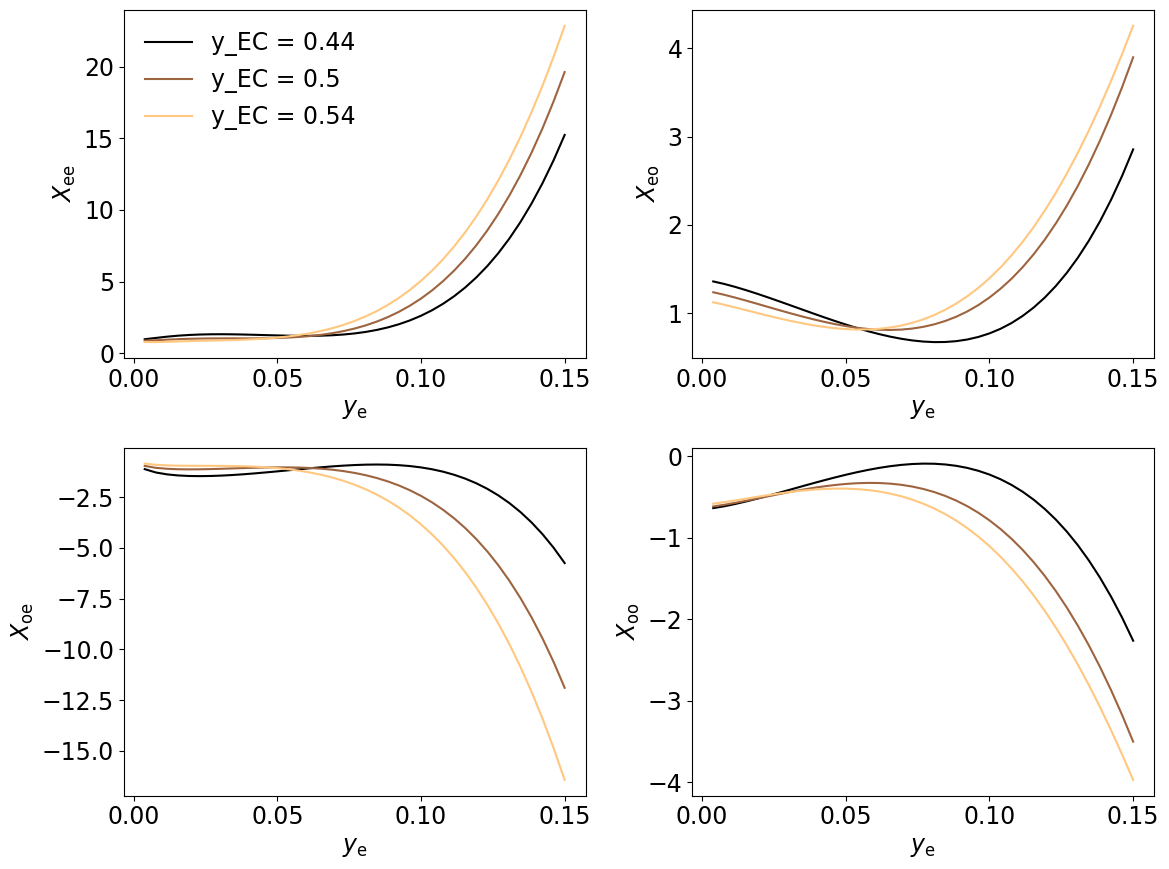

In [32]:
import matplotlib as mpl; 
y_e, y_EC = symbols("y_e y_EC",real=True)
y_EC_list = [0.44, 0.5, 0.54]
cop2 = mpl.cm.get_cmap("copper", len(y_EC_list))
y_e_array = np.linspace(0.000,0.15,40)
fig, Axs = plt.subplots(2,2, figsize=(12,9),tight_layout=True)
axs = Axs.flatten()
for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_ee_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[0].plot(x_plot, y_plot,"-",color=cop2(i),label=f"y_EC = {y_EC_list[i]}")
axs[0].set_ylabel("$X_\mathrm{ee}$")
axs[0].set_xlabel("$y_\mathrm{e}$")
axs[0].legend(frameon=False)

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_eo_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[1].set_ylabel("$X_\mathrm{eo}$")
axs[1].set_xlabel("$y_\mathrm{e}$")

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_oe_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[2].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[2].set_ylabel("$X_\mathrm{oe}$")
axs[2].set_xlabel("$y_\mathrm{e}$")

for i in range(len(y_EC_list)):
    x_plot = y_e_array
    y_plot = []
    for y_e_i in y_e_array:
        y_EC_i = y_EC_list[i]
        y_plot_sy = Fun_X_oo_y(y_e,y_EC)
        y_plot.append( y_plot_sy.subs({y_e:y_e_i, y_EC:y_EC_i})  ) 
    axs[3].plot(x_plot, y_plot,"-",color=cop2(i),label=y_EC_list[i])
axs[3].set_ylabel("$X_\mathrm{oo}$")
axs[3].set_xlabel("$y_\mathrm{e}$")

#### The remaining part show that Fig. 3 in the Self 2024 paper can be reproduced with symsy as well.

In [33]:
# alpha is the mole ratio between EC:EMC  -> m_EC/m_EMC = alpha

In [34]:
####  TD Factor function (eq 10) ####
def calculatedTDfactor(xx_log,xx_exp,m_e,alpha=1):
    #nopoints=10000
    #y_e=np.linspace(0,0.1,nopoints)
    m_EC=1/(m_bar_EC+m_bar_EMC/alpha)
    m_EMC=m_EC/alpha
    # m_e=(m_EC+m_EMC)*y_e/(1-2*y_e) # m_EC+m_EMC, this is a list!
    X_EMC=m_EMC/(m_EMC+m_EC+2*m_e)
    X_EC=m_EC/(m_EC+m_EMC+2*m_e)
    aEC=Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=alpha)
    tempGD = (
        - 0.5* m_EMC * xx_log(aEMC[:] / aEMC[0]) 
        - 0.5* m_EC  * xx_log(aEC[:]  / aEC[0] ) 
        )
    calculatedTDfactorRETURN=diff_central(m_e[4:],tempGD[:-4])
    return(calculatedTDfactorRETURN,tempGD,aEC,aEMC)

def calculatedTDF_sy(xx_log,xx_exp,m_e,alpha=1):
    # nopoints=100000
    # y_e=np.linspace(0,0.1,nopoints)
    m_EC=1/(m_bar_EC+m_bar_EMC/alpha)
    m_EMC=m_EC/alpha
    # m_e=(m_EC+m_EMC)*y_e/(1-2*y_e) # m_EC+m_EMC
    X_EMC=m_EMC/(m_EMC+m_EC+2*m_e)
    X_EC=m_EC/(m_EC+m_EMC+2*m_e)
    X_EMC_0=m_EMC/(m_EMC+m_EC+2*0)
    X_EC_0=m_EC/(m_EC+m_EMC+2*0)
    aEC=Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEC_0=Fun_a_EC_simplified(xx_exp,0,X_EMC_0,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=alpha)
    aEMC_0=Fun_a_EMC_simplified(xx_exp,0,X_EC_0,alpha=alpha)
    Integral = (
        - 0.5* m_EMC * xx_log(aEMC / aEMC_0) 
        - 0.5* m_EC  * xx_log(aEC / aEC_0 ) 
        )
    return Integral,aEC,aEMC,aEC_0,aEMC_0

nopoints=10000
# y_e=np.linspace(0,0.1,nopoints)
m_e_List =  np.linspace(0.0,1.31,nopoints)
TDF_Self,Integral_List_Self,aEC_Self,aEMC_Self = calculatedTDfactor(
    np.log,np.exp,m_e_List,alpha=1.18)

Integral_Li = []; aEC_Li = []; aEMC_Li = []
for m_e in m_e_List:
    Integral,aEC,aEMC,aEC_0,aEMC_0 = calculatedTDF_sy(sy.log,sy.exp,m_e,alpha=1.18)
    Integral_Li.append(Integral) 
    aEC_Li.append(aEC)
    aEMC_Li.append(aEMC)


In [35]:
# sy.diff - takes a long time, don't run unless necessary
x=symbols("x",real=True); 
Integral,aEC,aEMC,aEC_0,aEMC_0 = calculatedTDF_sy(sy.log,sy.exp,x,alpha=1e-5)
TDF_Salt_sy = diff(Integral,x)
TDF_Salt_Li = []
for m_e in m_e_List:
    TDF_Salt_Li.append(TDF_Salt_sy.subs({x:m_e}))


In [36]:
alp=symbols("alp",real=True)
Integral_v2,_,_,_,_ = calculatedTDF_sy(sy.log,sy.exp,x,alpha=alp)
TDF_Salt_v2_sy = diff(Integral_v2,x)

In [37]:
print(TDF_Salt_v2_sy)

-0.5*(2*x + 1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))*(1.0*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))*(0.0643425*x**0.5 - 0.051873*x**2 - 0.77664*x + 0.16575*x**1.5)*exp(61.8129921194409/(alp**2*(0.845895970414485 + 1/alp)**2*(1/((0.088062 + 0.104105/alp)*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))) + 1/(alp*(0.088062 + 0.104105/alp)*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))))**2*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))**2) - 3796.94841308823/(alp**3*(0.845895970414485 + 1/alp)**3*(1/((0.088062 + 0.104105/alp)*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))) + 1/(alp*(0.088062 + 0.104105/alp)*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))))**3*(1/(0.088062 + 0.104105/alp) + 1/(alp*(0.088062 + 0.104105/alp)))**3) + 21855.2829128935/(alp**4*(0.845895970414485 + 1/alp)**4*(1/((0.088062 + 0.104105/alp)*(1/(0.088062 + 0.104105/alp) + 1/(al

In [50]:
TDF_Salt_Li_v2 = []
for m_e in m_e_List:
    TDF_Salt_Li_v2.append(TDF_Salt_v2_sy.subs({x:m_e,alp:1e-5}))

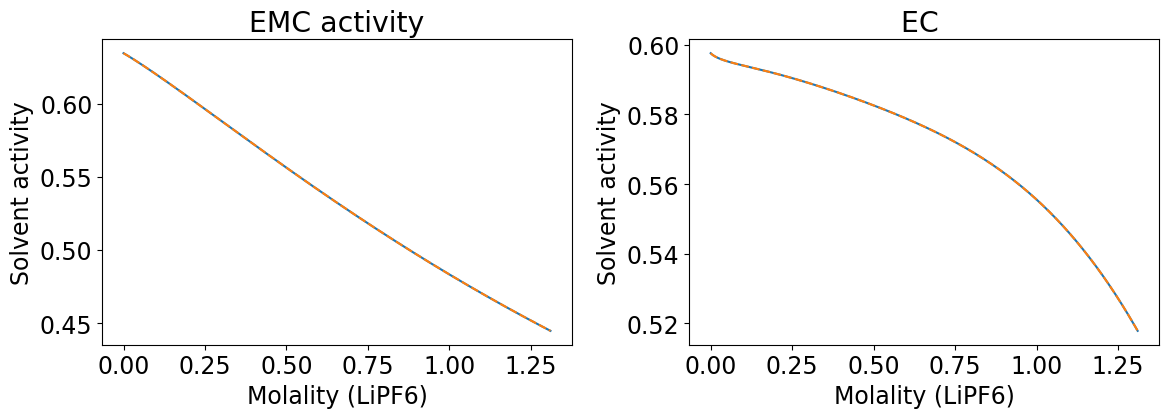

In [39]:
# plot activity
# Plot:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(m_e_List,aEC_Self,"-")
axs[0].plot(m_e_List,aEC_Li,"--")

axs[1].plot(m_e_List,aEMC_Self,"-")
axs[1].plot(m_e_List,aEMC_Li,"--")

axs[0].set_title("EMC activity")
axs[1].set_title("EC ")
for i in range(2):
    axs[i].set_ylabel("Solvent activity")
    axs[i].set_xlabel("Molality (LiPF6)")

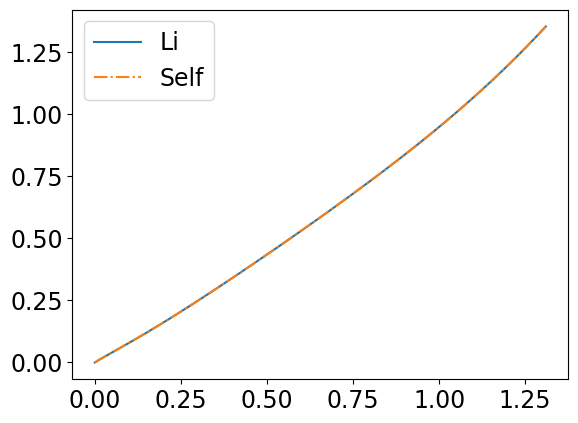

In [40]:
plt.plot(m_e_List,Integral_Li,"-",label="Li")
#plt.plot(m_e,tempGD,"-*",label="Li SELF")
plt.plot(m_e_List,Integral_List_Self,"-.",label="Self")
plt.legend()

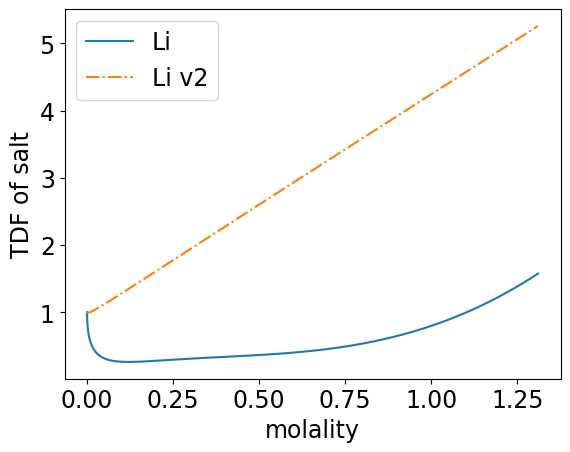

In [49]:
plt.plot(m_e_List,TDF_Salt_Li,'-',label="Li")
plt.plot(m_e_List,TDF_Salt_Li_v2,'-.',label="Li v2")
# plt.plot(m_e_List[6:],TDF_Self,'-.',label="Self")
plt.xlabel("molality")
plt.ylabel("TDF of salt")
plt.legend()